In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load full MPSA dataset
data_df = mavenn.load_example_dataset(name='mpsa')
data_df.head()

,training_set,y,dy,x
0,False,-3.751854,0.444200,AAAGCAAAA
1,True,-2.697741,0.369972,AAAGCAAAC
2,True,-2.242947,0.575121,AAAGCAAAG
3,False,-3.067251,0.357014,AAAGCAAAT
4,False,-2.987074,0.472637,AAAGCAACA


In [3]:
# Split into training and test data
ix = data_df['training_set']
training_df = data_df[ix].copy()
print(f'training N: {len(training_df)}')
      
# Split into training and test data
ix = data_df['training_set']
test_df = data_df[~ix].copy()
print(f'test N: {len(test_df)}')

training N: 17498
test N: 4431


In [4]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(regression_type='GE',
                     L=len(data_df['x'][0]),
                     alphabet='dna',
                     gpmap_type='pairwise',                     
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)


In [5]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'])

N = 21,929 observations set as training data.
Data shuffled.
Time to set data: 0.111 sec.


In [6]:
# Fit model to data
history = model.fit(learning_rate=.005,
                    epochs=1000,
                    batch_size=1000,
                    early_stopping=True,
                    early_stopping_patience=30)

 
LSMR            Least-squares solution of  Ax = b

The matrix A has    21929 rows  and       36 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       36

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.481e+02  5.397e+03   1.0e+00  2.5e-01
     1  2.13362e-02  1.342e+02  1.739e+03   9.1e-01  1.5e-01  8.6e+01  1.0e+00
     2  2.61004e-02  1.325e+02  6.140e+02   9.0e-01  3.6e-02  1.3e+02  1.1e+00
     3  2.79161e-02  1.325e+02  2.851e+02   8.9e-01  7.9e-03  2.7e+02  2.5e+00
     4  2.79728e-02  1.324e+02  6.533e+01   8.9e-01  1.6e-03  3.1e+02  3.3e+00
     5  2.87669e-02  1.324e+02  1.512e+01   8.9e-01  3.6e-04  3.2e+02  3.8e+00
     6  2.90448e-02  1.324e+02  1.508e+00   8.9e-01  3.5e-05  3.2e+02  3.9e+00
     7  2.90117e-02  1.324e+02  2.535e-01   8.9e-01  5.8e-06  3.3e+02  3.9e+00
     8  2.89991e-02  1.324e+02  7.240e-02   8.9e-01  1.6e-06  3.4e+02  3.9

18/18 [==============================] - 0s 9ms/step - loss: 626.4827 - val_loss: 626.7598
Epoch 66/1000
18/18 [==============================] - 0s 9ms/step - loss: 628.9230 - val_loss: 625.3186
Epoch 67/1000
18/18 [==============================] - 0s 9ms/step - loss: 627.2944 - val_loss: 629.4973
Epoch 68/1000
18/18 [==============================] - 0s 9ms/step - loss: 626.6798 - val_loss: 620.0750
Epoch 69/1000
18/18 [==============================] - 0s 10ms/step - loss: 628.8125 - val_loss: 626.7445
Epoch 70/1000
18/18 [==============================] - 0s 10ms/step - loss: 626.2958 - val_loss: 619.2983
Epoch 71/1000
18/18 [==============================] - 0s 10ms/step - loss: 628.9382 - val_loss: 633.9742
Epoch 72/1000
18/18 [==============================] - 0s 10ms/step - loss: 627.9380 - val_loss: 630.0108
Epoch 73/1000
18/18 [==============================] - 0s 11ms/step - loss: 626.1013 - val_loss: 619.7529
Epoch 74/1000
18/18 [==============================] - 0s 9ms/st

In [7]:
# Save model
model.save('mpsa_ge_pairwise')

Model saved to these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [8]:
# Load model
model = mavenn.load('mpsa_ge_pairwise')

Model loaded from these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [9]:
# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values

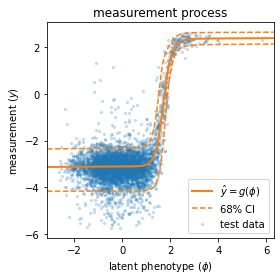

In [10]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

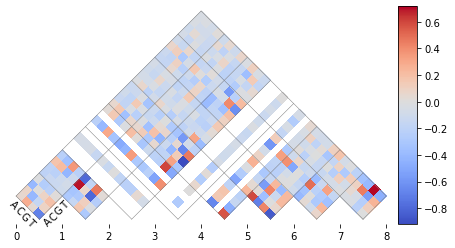

In [11]:
# Plot pairwise parameters
theta_dict = model.get_theta(gauge="uniform")
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(theta_dict['theta_lclc'], 
                        alphabet=theta_dict['alphabet'],
                        ax=ax);